<div style = "text-align: center; color: black; font-family: Times New Roman;">
  <strong><h1>NASDAQ TIME-SERIES WITH LASSO <strong></h1>
</div>

<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  We will proceed running a Lasso Regression analysis on the differenced dependent variable NASDAQ. We will begin by setting the libraries that we will use in this analysis:
</p>

<div style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  <ul style="display: inline-block; text-align: left;">
    <li><strong>import pandas as pd</strong>: loading in data, working with pandas data frames, and differencing the data</li>
    <li><strong>import numpy as np</strong>: Built in numpy functions</li>
    <li><strong>from sklearn.model_selection import train_test_split</strong>: split our data into test/train using shuffle = False due to time-series data</li>
    <li><strong>from sklearn.metrics import mean_squared_error</strong>: calculate MSE & RMSE scores</li>
    <li><strong>from sklearn.linear_model import LassoCV</strong>: run the LASSO regression</li>
    <li><strong>from sklearn.preprocessing import StandardScaler</strong>: Scaling the data for LASSO</li>
    <li><strong>import matoplotlib.pyplot as plt</strong>: Plotting Actual versus Prdicted Test Data</li>
  </ul>
</div>

In [15]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  Then, we will load in our data and rename column names for easier and more descriptive analysis.
</p>

In [16]:
# Load in the data 
data = pd.read_csv('merged_data.csv')
data.rename(columns={'CPALWE01USQ661N': 'CPI', 'S&P 500 ^GSPC': 'S&P_500', 'NASDAQ ^IXIC': 'NASDAQ', 'Dow Jones ^DJI':'Dow_Jones', 'RealInterestRate':'Real_IR', 'UnemploymentRate': 'Unemployment_Rate', 'FedFundsRate': 'Federal_Funds_Rate'}, inplace = True)

dates = data['Date'] # keeping for future plotting
data

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
...,...,...,...,...,...,...,...,...,...,...
123,2022-10-01,3871.979980,10988.150391,32732.949219,126.044174,1.797332,3.6,3.4,21429.5,3.08
124,2023-01-01,4076.600098,11584.549805,34086.039062,127.208058,1.783099,3.5,2.8,21364.4,4.33
125,2023-04-01,4169.479980,12226.580078,34098.160156,128.770113,1.443914,3.4,2.4,20924.5,4.83
126,2023-07-01,4588.959961,14346.019531,35559.531250,129.949384,1.426047,3.5,4.4,20744.8,5.12


<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  Then, as explained in the Time-series Backrgound notebook we will be differencing the data using the built in python function 
    <strong>.diff()</strong>. Due to differencing, the first row will be NA; therefore, we will drop the corresponding row. 
</p>

In [17]:
# differencing the data using .diff -> ARIMA (0,1,0)
data['NASDAQ_Diff'] = data['NASDAQ'].diff()

data = data.dropna() #drops first row with NA values due to differencing
data

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate,NASDAQ_Diff
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73,-41.530029
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25,2.150024
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10,24.339966
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02,91.170044
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96,-34.920044
...,...,...,...,...,...,...,...,...,...,...,...
123,2022-10-01,3871.979980,10988.150391,32732.949219,126.044174,1.797332,3.6,3.4,21429.5,3.08,-1402.540039
124,2023-01-01,4076.600098,11584.549805,34086.039062,127.208058,1.783099,3.5,2.8,21364.4,4.33,596.399414
125,2023-04-01,4169.479980,12226.580078,34098.160156,128.770113,1.443914,3.4,2.4,20924.5,4.83,642.030273
126,2023-07-01,4588.959961,14346.019531,35559.531250,129.949384,1.426047,3.5,4.4,20744.8,5.12,2119.439453


<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  Then, we will begin running our Lasso Regressive Model using the differencing data. For our independent variables, it will include all macroeconomic variables and the NASDAQ differencing column and we will select all rows from April 1 1992 - July 1 2023. This represents t-1, the previous quarter, for our time-series analysis. For our dependent variable, we will be selecting the NASDAQ differencing column from July 1 1992 - October 1 2023. This represents t, the current quarter, for our time-series analysis. 
</p>

In [18]:
# defining independent and dependent variables 
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate', 'NASDAQ_Diff']
dependent_variable = ['NASDAQ_Diff']

x = data[independent_variables].iloc[0:-1] # includes t-1
y = data[dependent_variable].iloc[1:] # includes t

<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  Then, using <strong>sklearn</strong>, we split our data into an 80/20 train-test split with <strong>shuffle = False</strong>, as done in previous notebooks.
  We ran LASSO regression similarly to the NASDAQ notebook, where we transform <code>x_train</code> and <code>x_test</code> to be <strong>standard normal</strong>, meaning the mean equals 0 and the standard deviation equals 1.
</p>

<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  For <strong>LassoCV</strong>, we set <strong>cv = 5</strong> and <strong>random_state = 42</strong> to ensure consistent results.
  In our analysis, we focused on:
</p>

<ul style="font-family: 'Times New Roman'; font-size: 18px; color: black; text-align: center; list-style-type: none; padding-left: 0;">
  <li>→ <strong>RMSE</strong> score to compare model accuracy</li>
  <li>→ Optimal <strong>lambda</strong> to see how quickly variables approach zero</li>
  <li>→ Final <strong>beta values</strong> to interpret strength and direction of predictors</li>
</ul>

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

dates = dates.iloc[y_test.index]

In [20]:
# Transform x values into standard normal (mean = 0, std = 1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [21]:
# running lasso with 5 folds on training set
lasso = LassoCV(cv = 5, random_state = 42)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel()) # asked generative ai about ravel to supress warning
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

In [22]:
# predicting the data with the test set
y_pred = lasso.predict(x_test_scaled)
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
mse = rmse ** 2

In [23]:
cpi = coefficient[0]
real_ir = coefficient[1]
unemployment = coefficient[2]
gdp_growth = coefficient[3]
m2_supply = coefficient[4]
fed_funds = coefficient[5]
nasdaq_diff = coefficient[6]
    
print(f'-Test RMSE:{rmse:.2f}---Optimal Lambda:{optimal_lambda:.2f}---CPI:{cpi:.2f}---Real Interest Rate:{real_ir:.2f}---Unemployment Rate:{unemployment:.2f}---GDP Growth:{gdp_growth:.2f}---M2 Supply:{m2_supply:.2f}---Federal Funds Rate:{fed_funds:.2f}---NASDAQ Difference:{nasdaq_diff:.2f}-')

-Test RMSE:1102.88---Optimal Lambda:5.37---CPI:-0.00---Real Interest Rate:-21.49---Unemployment Rate:15.27---GDP Growth:83.13---M2 Supply:32.61---Federal Funds Rate:-0.00---NASDAQ Difference:12.09-


<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  Using our coefficients generated from lasso, the three most important predictors for NASDAQ using differenced data was Real Interest Rate, GDP Growth, and M2 Money Supply. This is not far off from what we found out in Multiple Linear Regression and Lasso Regressive analysis, beside the higher coefficient value of Real Interest Rate. If interest rate were to be an important indicator for any stock market index it would be NASDAQ, as higher interest rates make borrowing more expensive and risky so consumers deter from buying tech stocks. However, our new predictor for time-series, NASDAQ Difference was a slight positive driver for NASDAQ, meaning that predicting the current quarter using the past quarter is somewhat helpful. To visualize, we will plot Actual vs Predicted NASDAQ for time-series, which will look different compared to our Multiple Linear Regression Plot because of the differencing componenent. This makes NASDAQ more sparatic and less smooth, showing the raw changes in the index.
</p>

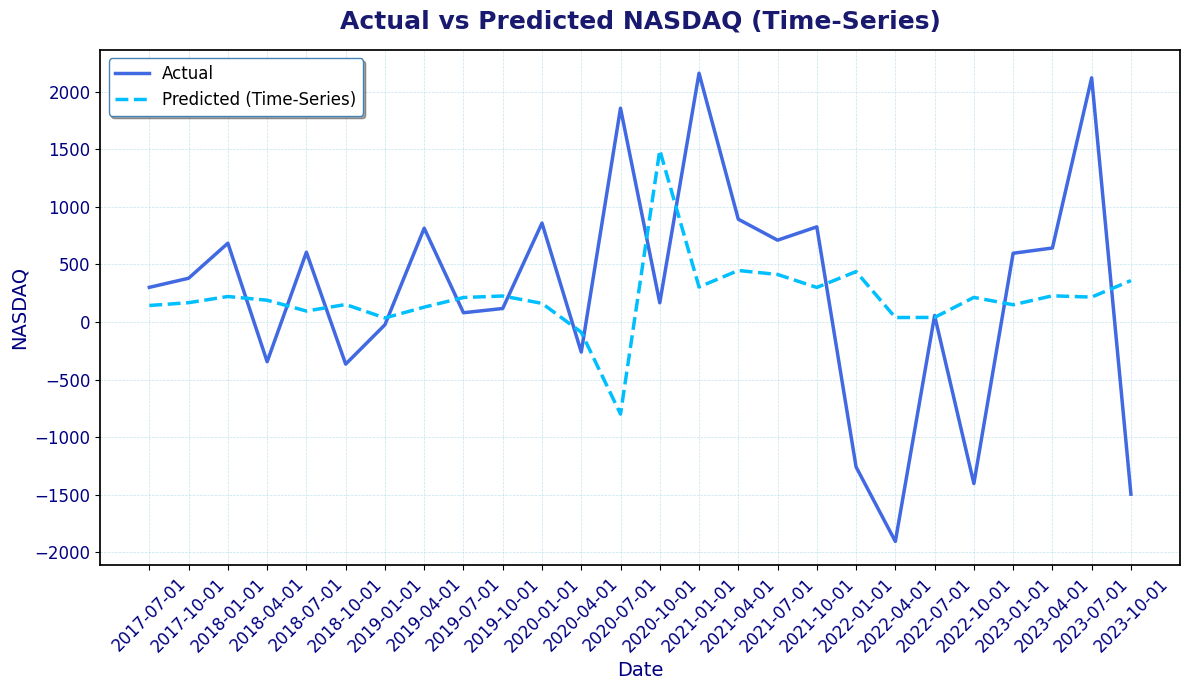

In [24]:
plt.figure(figsize = (12, 7))
plt.plot(dates, y_test, label = 'Actual', color = 'royalblue', linewidth = 2.5)
plt.plot(dates, y_pred, 
         label = 'Predicted (Time-Series)', 
         color = 'deepskyblue', linewidth = 2.5, linestyle = '--')

plt.title('Actual vs Predicted NASDAQ (Time-Series)', fontsize = 18, fontweight = 'bold', pad = 15, color = 'midnightblue')
plt.xlabel('Date', fontsize = 14, color = 'navy')
plt.ylabel('NASDAQ', fontsize = 14, color = 'navy')
plt.xticks(rotation = 45, fontsize = 12, color = 'navy')
plt.yticks(fontsize = 12, color = 'navy')

ax = plt.gca()
ax.set_facecolor('white') 
ax.figure.set_facecolor('white') 

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.25)
    spine.set_color('black')

plt.grid(visible = True, linestyle = '--', linewidth = 0.5, alpha = 0.7, color = 'lightblue')
plt.legend(loc = 'upper left', fontsize = 12, frameon = True, shadow = True, edgecolor = 'steelblue')
plt.tight_layout()
plt.show()

<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
  Overall, our time-series model failed to properly predict NASDAQ differenced values using macroeconomic factors and the previous quarter. This may be due to the fact that the independent variables were differenced, and macroeconomic indicators tend to shift gradually over time, unlike NASDAQ, which is tech-heavy and reacts quickly to market sentiment. While both are shaped by consumer expectations, the NASDAQ is especially sensitive to changes in interest rates and growth forecasts, making it more reactive and volatile. As a result, the model underestimated the steep movements in the actual NASDAQ, particularly around COVID-19. However, the model still provided value by highlighting which variables had influence, a pattern that remained fairly consistent across all models, and confirmed that lagged NASDAQ data alone did not carry strong predictive power, but added the most in NASDAQ analysis. Overall, our actual versus predicted was a bit lagged and lacked extreme magnitude.
</p>

<p style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; color: black;">
 During the 2020 pandemic, NASDAQ stock behaved a lot different compared to S&P 500 and Dow Jones as there was no decrease in the actual values and the differenced values. As mentioned before, this was due to an increase in demand for technology during COVID-19.
</p>